<a href="https://colab.research.google.com/github/tylerlum/self_driving_car/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Import data
!git clone https://github.com/tylerlum/self-driving-car-data-track-1

Cloning into 'self-driving-car-data-track-1'...
remote: Enumerating objects: 24393, done.
remote: Counting objects: 100% (24393/24393), done.
remote: Compressing objects: 100% (24393/24393), done.
remote: Total 24393 (delta 0), reused 24393 (delta 0), pack-reused 0
Receiving objects: 100% (24393/24393), 311.87 MiB | 35.30 MiB/s, done.
Checking out files: 100% (24592/24592), done.


In [46]:
!ls self-driving-car-data-track-1

driving_log.csv  IMG


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle

In [48]:
## Store data
datadir = 'self-driving-car-data-track-1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_104.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_104.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_104.jpg,0.0,0.0,0.0,0.000079
1,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_208.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_208.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_208.jpg,0.0,0.0,0.0,0.000079
2,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_311.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_311.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_311.jpg,0.0,0.0,0.0,0.000078
3,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_417.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_417.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_417.jpg,0.0,0.0,0.0,0.000081
4,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_517.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_517.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_517.jpg,0.0,0.0,0.0,0.000078


In [49]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_12_08_17_31_10_104.jpg,left_2018_12_08_17_31_10_104.jpg,right_2018_12_08_17_31_10_104.jpg,0.0,0.0,0.0,0.000079
1,center_2018_12_08_17_31_10_208.jpg,left_2018_12_08_17_31_10_208.jpg,right_2018_12_08_17_31_10_208.jpg,0.0,0.0,0.0,0.000079
2,center_2018_12_08_17_31_10_311.jpg,left_2018_12_08_17_31_10_311.jpg,right_2018_12_08_17_31_10_311.jpg,0.0,0.0,0.0,0.000078
3,center_2018_12_08_17_31_10_417.jpg,left_2018_12_08_17_31_10_417.jpg,right_2018_12_08_17_31_10_417.jpg,0.0,0.0,0.0,0.000081
4,center_2018_12_08_17_31_10_517.jpg,left_2018_12_08_17_31_10_517.jpg,right_2018_12_08_17_31_10_517.jpg,0.0,0.0,0.0,0.000078


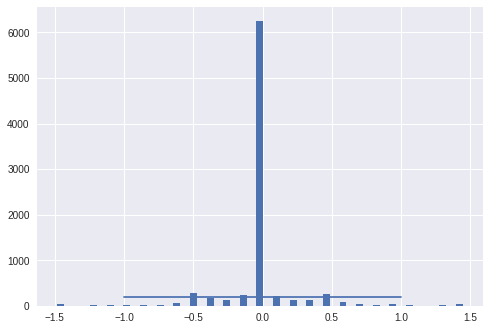

In [50]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 8197
Removed: 6230
Remaining: 1967


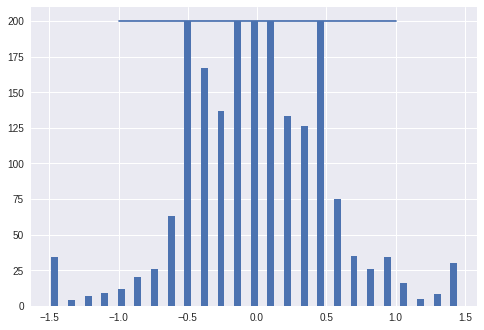

In [51]:
## Unskew data: for bins with >samples_per_bin, shuffle them and remove enough to have samples_per_bin 
print('Total data: {0}'.format(len(data)))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))